<a href="https://colab.research.google.com/github/benjamininden/AI-teaching-python/blob/main/COVID19RadiographyNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for chest X-ray images

This tutorial demonstrates simple use cases for a number of deep learning techniques: Using a dataset and augmenting it, building and training a convolutional neural network from scratch, using a pre-trained network, and using the SHAP method to understand the behaviour of a trained neural network. The tutorial shows how to classify chest X-ray images as belonging to healthy subjects or those infected with COVID-19. (Note that COVID-19 patients with mild symptoms would not normally show abnormalities on the X-ray images, these cases are not considered here.) A [kaggle dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) is used for that purpose. If you are interested, lots of [academic papers](https://scholar.google.de/scholar?hl=en&as_sdt=0%2C5&q=COVID-19+chest+X-ray&btnG=) have been published on the subject.


# Preparations

The first step is to install some Python packages that are missing (at least, missing on Google Colaboratory), and download and unzip the dataset. For the download to work, you will need to upload your personal Kaggle json file. Upload it when prompted, or modify the code to upload the data directly / run it on a local machine where the dataset is already present.

We are only interested in two classes from this dataset --- normal lungs versus those of people infected with COVID-19. Therefore, images from other classes are deleted.

In [1]:
! pip install -q shap
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tawsifurrahman/covid19-radiography-database
! unzip -q covid19-radiography-database.zip
! rm -rf "COVID-19_Radiography_Dataset/Lung_Opacity"
! rm -rf "COVID-19_Radiography_Dataset/Viral Pneumonia"

     |████████████████████████████████| 356 kB 4.2 MB/s 


Saving kaggle.json to kaggle.json
 99% 739M/745M [00:31<00:00, 25.8MB/s]
100% 745M/745M [00:31<00:00, 24.7MB/s]


Next, packages are imported, and some parameters set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import skimage.io
import skimage.transform
import sklearn
import shap
import os

random_seed = 1
image_size = 150

We use a rather conventional approach to load the data set as a numpy array of grayscale images *X*, and an array of labels *y*. (The function used has been adapted from [here](https://www.kaggle.com/suryaaseran/pneumonia-detection-simple-cnn-beginner-friendly).) The order of the samples is randomly shuffled, so the proportion of classes in the different subsets used during training and validation will be approximately equal.

In [3]:
labels = ['COVID', 'Normal']
def load_data(data_dir):
    data = []
    target = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_orig = skimage.io.imread(os.path.join(path, img), as_gray=True)
                img_res = skimage.transform.resize(img_orig, (image_size, image_size),
                          anti_aliasing=False).reshape(image_size, image_size, 1)
                data.append(img_res)
                target.append(class_num)
            except Exception as e:
                print(e)
    return np.array(data), np.array(target)

X, y = load_data("./COVID-19_Radiography_Dataset")
X, y = sklearn.utils.shuffle(X, y, random_state=random_seed)

# The convolutional neural network

A [data augmentatio](https://www.tensorflow.org/tutorials/images/data_augmentation)n layer is defined to change the images randomly, either using a horizontal flip, or using a slight rotation. Without this, the neural network would soon begin to overfit on the training data. The data augmentation layer can either be mapped on the dataset before learning begins, or (as here), it can transform the input to the neural network dynamically during training.

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)])

Now we specify the architecture of the convolutional neural network. The [keras Sequential model API](https://keras.io/guides/sequential_model/) is a convenient way to specify neural networks where each layer has at most one input layer and one output layer.

In [5]:
model=tf.keras.Sequential()
model.add(data_augmentation)
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4, input_shape=(256,)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

After compiling the specified network, we can start the training. An accuracy of about 88% is typically reached with this small and unsophisticated convolutional neural network. 

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', metrics = [tf.keras.metrics.BinaryAccuracy(),
              tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
trainer=model.fit(x=X, y=y, validation_split=0.25,epochs=12,verbose=2)

Epoch 1/12
324/324 - 40s - loss: 0.5116 - binary_accuracy: 0.7438 - precision: 0.7452 - recall: 0.9912 - val_loss: 0.4740 - val_binary_accuracy: 0.7830 - val_precision: 0.7995 - val_recall: 0.9446
Epoch 2/12
324/324 - 10s - loss: 0.4696 - binary_accuracy: 0.7673 - precision: 0.7757 - recall: 0.9625 - val_loss: 0.4409 - val_binary_accuracy: 0.7885 - val_precision: 0.7868 - val_recall: 0.9809
Epoch 3/12
324/324 - 10s - loss: 0.4503 - binary_accuracy: 0.7795 - precision: 0.7913 - recall: 0.9516 - val_loss: 0.4180 - val_binary_accuracy: 0.8100 - val_precision: 0.8080 - val_recall: 0.9758
Epoch 4/12
324/324 - 10s - loss: 0.4328 - binary_accuracy: 0.7914 - precision: 0.8008 - recall: 0.9543 - val_loss: 0.4016 - val_binary_accuracy: 0.8050 - val_precision: 0.7990 - val_recall: 0.9852
Epoch 5/12
324/324 - 10s - loss: 0.4171 - binary_accuracy: 0.8041 - precision: 0.8151 - recall: 0.9494 - val_loss: 0.3840 - val_binary_accuracy: 0.8407 - val_precision: 0.8452 - val_recall: 0.9614
Epoch 6/12
324/

# Evaluating the results

We plot how loss and accuracy on the training / validation set change during training.

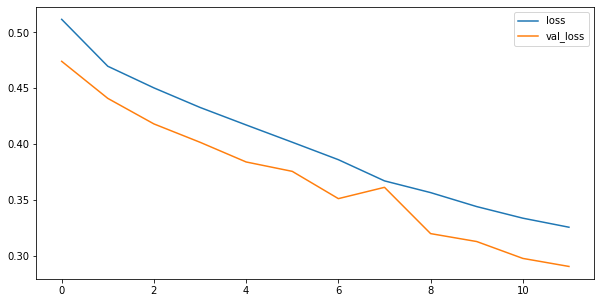

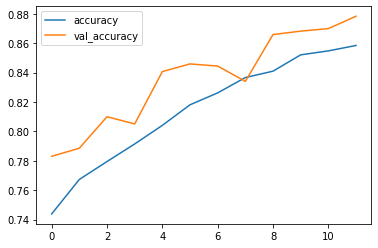

In [7]:
plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

plt.plot(trainer.history["binary_accuracy"],label="accuracy")
plt.plot(trainer.history["val_binary_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')
plt.show()

Besides knowing the performance of the system, it is also interesting to understand why the neural network puts an image into one class as opposed to the other. That way, it is possible to detect any situations in which the neural networks relies on features in the input that are not relevant to its classification in the real world but are artifacts of the dataset, and/or where it relies on features that could lead to different outcomes for different demographic groups (causing bias / discrimmination issues). In these cases, it is possible to modify the dataset or and/or learning procedure accordingly. Understanding a learner in this way is the goal of the field of Explainable Artificial Intelligence (XAI). One method that can be applied on all kinds of learners is SHAP. SHAP values provide a measure of the relative contribution of a particular input feature to the classification outcome in the context of the other features' values. Deep SHAP is a method to calulate approximate SHAP values relatively quickly for deep neural networks. Below, we use some code adapted from [the SHAP website](https://github.com/slundberg/shap) to calculate pixels that strongly support (red) or contradict (blue) the COVID-19 classification.

We build a new model without the data augmentation layer (but with all other trained layers) as a workaround here because SHAP cannot handle the data augmentation layer at the time of writing. 100 images are chosen randomly as background against which to explain the differences in 10 example images.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


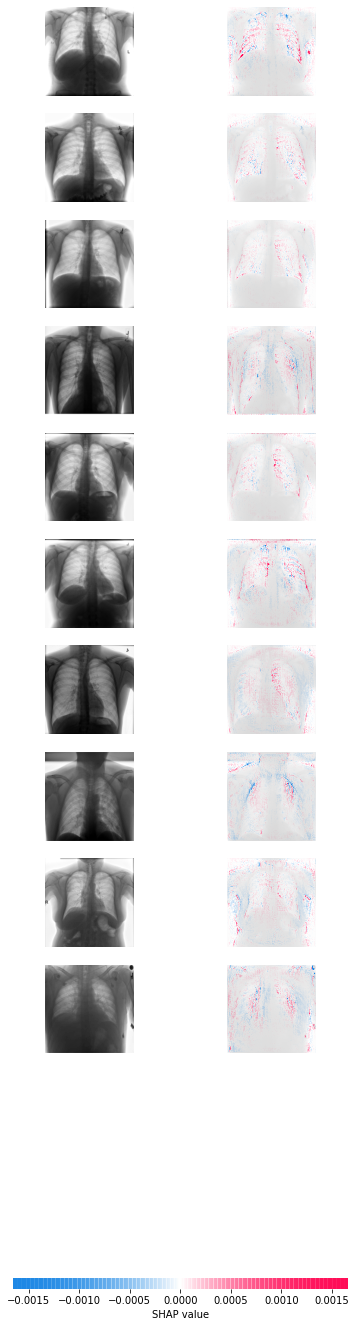

In [8]:
valmodel = tf.keras.Sequential()
for i in range(1, len(model.layers)):
    valmodel.add(model.get_layer(index=i))
valmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', metrics = ['accuracy'])
# select a set of background examples to take an expectation over
sample = np.random.choice(X.shape[0], size=110, replace=False)
background = X[sample[:100]]
examples = X[sample[100:]]
# explain predictions of the model on ten images
e = shap.DeepExplainer(valmodel, background)
shap_values = e.shap_values(examples)
shap.image_plot(shap_values, -examples, width=150)

Features that [physicians commonly use](https://www.elsevier.es/en-revista-radiologia-english-edition--419-articulo-radiologic-diagnosis-patients-with-covid-19-S2173510721000033) include hazy gray areas called ground-glass opacities, whitish opaque areas with a reticular pattern, and lung consolidations (volumes filled with something other than air), which might appear as white blobs on both sides of the lung.

From the SHAP images, it appears that the trained model indeed identifies these kinds of features. However, features at the border of the images also have a strong influence on the class, which seems to hint at some artifacts in the dataset.

# Using a pre-trained network

Transfer learning is an approach to using deep neural networks where, instead of training one from scratch, one takes a network that has already been trained on a similar dataset. The lower layers of this network should already have learned to recognise features that are useful for classification. The top layer(s) are removed, and new untrained top layer(s) suitable to the task of interest are added instead. Then only these are trained while the weights of the lower layers remain frozen. That way, good performance can often be reached when data samples or computing power for training are limited.

Here, we follow a [keras tutorial](https://keras.io/guides/transfer_learning/) and use the [Xception network](https://arxiv.org/abs/1610.02357) with weights trained on the [ImageNet](https://image-net.org/) task. This networks takes colour images as input, so we have to convert the grayscale images to images with three colour channels. However, the resulting numpy array would use too much memory (for many machines), therefore we make use of the [tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class, wich can load samples into memory dynamically. The [image_dataset_from_directory](https://keras.io/api/preprocessing/image/) function also takes care of the colour conversion.

In [9]:
train_rds = tf.keras.preprocessing.image_dataset_from_directory("COVID-19_Radiography_Dataset",
            validation_split=0.25, subset="training", image_size=(image_size, image_size), seed=random_seed, label_mode="binary")
val_rds = tf.keras.preprocessing.image_dataset_from_directory("COVID-19_Radiography_Dataset",
          validation_split=0.25, subset="validation", image_size=(image_size, image_size), seed=random_seed, label_mode="binary")
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/127.5, offset=-1.0)

train_ds = train_rds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))
val_ds = val_rds.map(lambda x, y: (data_augmentation(normalization_layer(x), training=True), y))

Found 13808 files belonging to 2 classes.
Using 10356 files for training.
Found 13808 files belonging to 2 classes.
Using 3452 files for validation.


The code below provides an example of how to specify a neural network with the [keras functional API](https://keras.io/guides/functional_api/).

In [10]:
base_model = tf.keras.applications.Xception(
    weights="imagenet",  input_shape=(image_size, image_size, 3), include_top=False)
base_model.trainable = False
inputs = tf.keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
trainer=model.fit(x=train_ds, validation_data=val_ds, epochs=12,verbose=2)

83689472/83683744 [==============================] - 3s 0us/step
Epoch 1/12
324/324 - 118s - loss: 0.3771 - accuracy: 0.8333 - val_loss: 0.2996 - val_accuracy: 0.8751
Epoch 2/12
324/324 - 109s - loss: 0.2939 - accuracy: 0.8766 - val_loss: 0.2672 - val_accuracy: 0.8963
Epoch 3/12
324/324 - 108s - loss: 0.2844 - accuracy: 0.8868 - val_loss: 0.2558 - val_accuracy: 0.8940
Epoch 4/12
324/324 - 108s - loss: 0.2723 - accuracy: 0.8885 - val_loss: 0.2459 - val_accuracy: 0.9018
Epoch 5/12
324/324 - 110s - loss: 0.2682 - accuracy: 0.8918 - val_loss: 0.2371 - val_accuracy: 0.9041
Epoch 6/12
324/324 - 110s - loss: 0.2613 - accuracy: 0.8921 - val_loss: 0.2395 - val_accuracy: 0.9021
Epoch 7/12
324/324 - 109s - loss: 0.2579 - accuracy: 0.8980 - val_loss: 0.2379 - val_accuracy: 0.9038
Epoch 8/12
324/324 - 108s - loss: 0.2519 - accuracy: 0.9010 - val_loss: 0.2351 - val_accuracy: 0.9070
Epoch 9/12
324/324 - 107s - loss: 0.2538 - accuracy: 0.8958 - val_loss: 0.2261 - val_accuracy: 0.9111
Epoch 10/12
324/3

Again, we plot how loss and accuracy on the training / validation set change during training. With this approach, we should be able to reach accuracies of about 91%. Of course, with careful tweaking of the network architecture and training procedure, higher accuracies are possible.

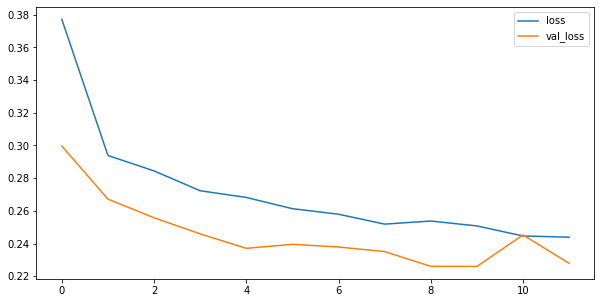

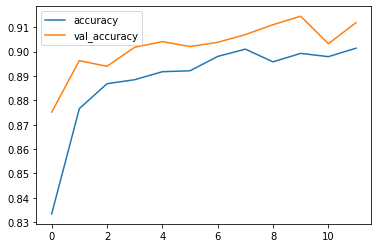

In [11]:
plt.figure(figsize=(10,5))
plt.plot(trainer.history["loss"],label="loss")
plt.plot(trainer.history["val_loss"],label="val_loss")
plt.legend()
plt.show()

plt.plot(trainer.history["accuracy"],label="accuracy")
plt.plot(trainer.history["val_accuracy"],label="val_accuracy")
plt.legend(loc='upper left')
plt.show()